In [1]:
!git clone https://github.com/albertakn/text_2_image.git
!pip install -r text_2_image/requirements.txt

Cloning into 'text_2_image'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 114 (delta 33), reused 68 (delta 7), pack-reused 0
Receiving objects: 100% (114/114), 1.05 MiB | 4.37 MiB/s, done.
Resolving deltas: 100% (33/33), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
from google.colab import drive

#Чтобы модель заработала, необходимо скачать веса отсюда:
#https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/v1-5-pruned-emaonly.ckpt
#Я сделал это заранее, поэтому просто подгружаю их из своего google drive
drive.mount('/content/drive')
!cp drive/MyDrive/diploma/v1-5-pruned-emaonly.ckpt text_2_image/data/v1-5-pruned-emaonly.ckpt

Mounted at /content/drive


# Download concept

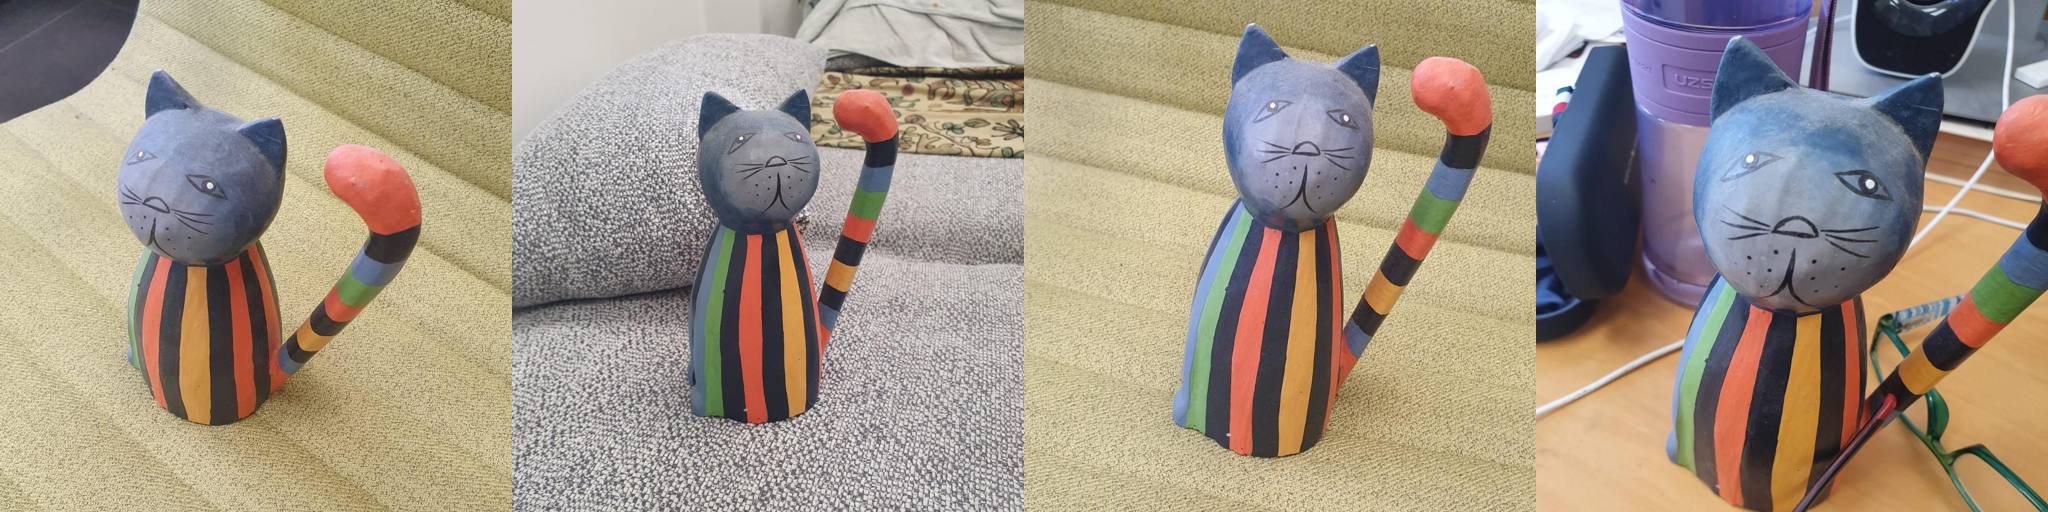

In [1]:
import requests
import glob
from io import BytesIO
import os
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


urls = [
      "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
      "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
      ## You can add additional images here
]

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]

images = []
for file_path in os.listdir(save_path):
  try:
      image_path = os.path.join(save_path, file_path)
      images.append(Image.open(image_path).resize((512, 512)))
  except:
    print(f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")
image_grid(images, 1, len(images))

# Prepare model

In [2]:
from transformers import CLIPTokenizer
from PIL import Image
from text_2_image.stable_diffusion.util.model_loader import load_models_from_standard_weights
from text_2_image.stable_diffusion.pipeline.pipeline import generate
from text_2_image.textual_inversion.textual_inversion import run_textual_inversion

device = 'cuda'
tokenizer = CLIPTokenizer("text_2_image/data/vocab.json", merges_file="text_2_image/data/merges.txt")
models = load_models_from_standard_weights('text_2_image/data/v1-5-pruned-emaonly.ckpt', 'cuda')


# Initialize hyperparameters for textual inversion

In [3]:

what_to_teach = "object"
placeholder_token = "<cat-toy>"
initializer_token = "toy"

hyperparameters = {
    "learning_rate": 1e-4,
    "scale_lr": True,
    "max_train_steps": 4500,
    "save_steps": 250,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "seed": 42,
    "output_dir": "/content/sd-concept-output",
    "what_to_teach": what_to_teach,
    "placeholder_token": placeholder_token,
    "initializer_token": initializer_token,
    "save_path": "/content/my_concept",
    "device": "cuda"
}
!mkdir sd-concept-output

mkdir: cannot create directory ‘sd-concept-output’: File exists


# Fine tunning

In [4]:
models = run_textual_inversion(models, tokenizer, hyperparameters)

Launching training on one GPU.


  0%|          | 0/4500 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:07<00:00,  6.40it/s]


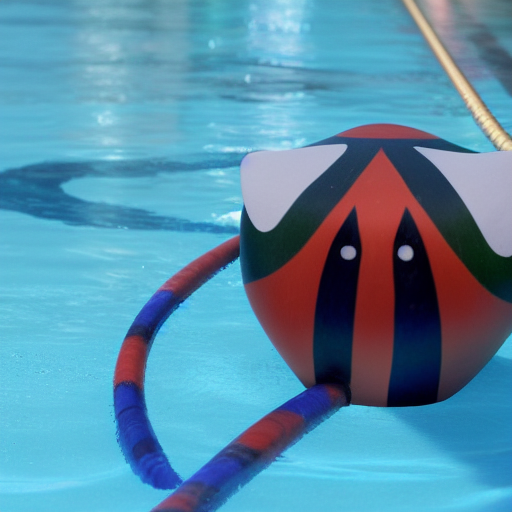

In [22]:

prompt = "A <cat-toy> in a swimming pool. The picture shows the pool"
uncond_prompt = ""
do_cfg = True
cfg_scale = 8 # min: 1, max: 14


sampler = "ddpm"
num_inference_steps = 50
# seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    # seed=seed,
    models=models,
    device="cuda",
    idle_device="cuda",
    tokenizer=tokenizer,
)

Image.fromarray(output_image)


100%|██████████| 50/50 [00:07<00:00,  6.38it/s]


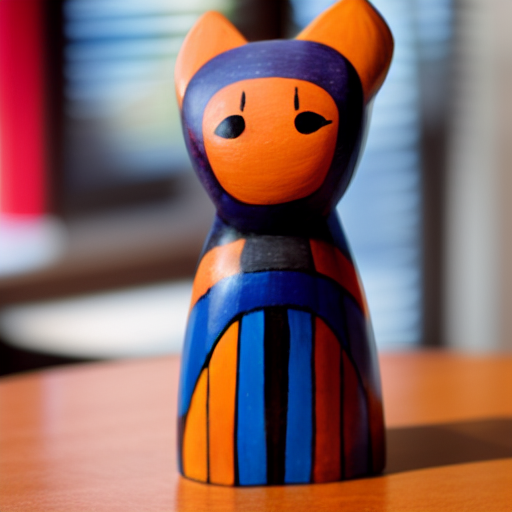

In [16]:

prompt = "A <cat-toy> on a table"
uncond_prompt = ""
do_cfg = True
cfg_scale = 8 # min: 1, max: 14


sampler = "ddpm"
num_inference_steps = 50
# seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    # seed=seed,
    models=models,
    device="cuda",
    idle_device="cuda",
    tokenizer=tokenizer,
)

Image.fromarray(output_image)


100%|██████████| 50/50 [00:07<00:00,  6.39it/s]


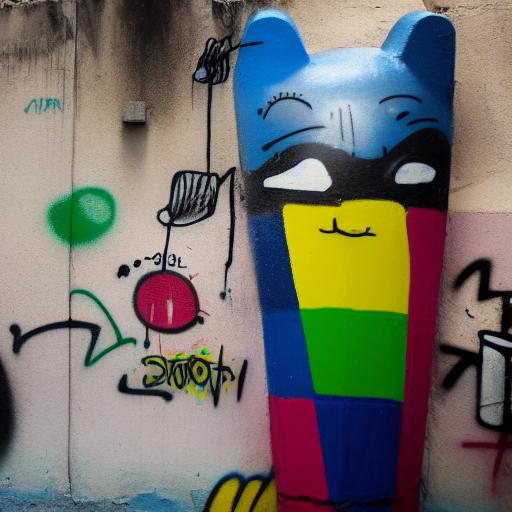

In [19]:

prompt = "grafitti in a favela wall with a <cat-toy> painted on it"
uncond_prompt = ""
do_cfg = True
cfg_scale = 8 # min: 1, max: 14


sampler = "ddpm"
num_inference_steps = 50
# seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    # seed=seed,
    models=models,
    device="cuda",
    idle_device="cuda",
    tokenizer=tokenizer,
)

Image.fromarray(output_image)


100%|██████████| 50/50 [00:07<00:00,  6.35it/s]


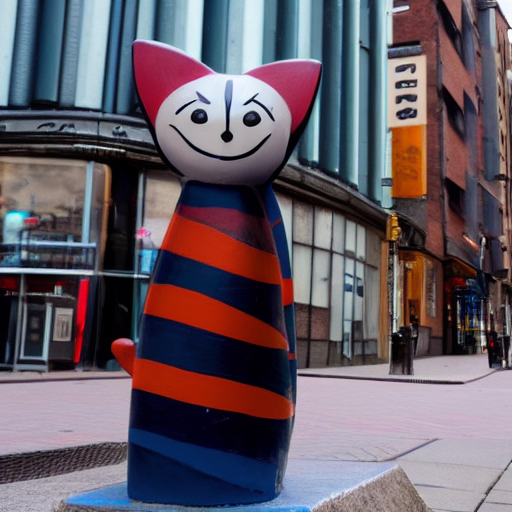

In [18]:

prompt = "A <cat-toy> stands at a crossroads in the city"
uncond_prompt = ""
do_cfg = True
cfg_scale = 8 # min: 1, max: 14


sampler = "ddpm"
num_inference_steps = 50
# seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    # seed=seed,
    models=models,
    device="cuda",
    idle_device="cuda",
    tokenizer=tokenizer,
)

Image.fromarray(output_image)